In [256]:
from revision import CryptoWikiFetcher

crypto_name = input("Enter the name of the cryptocurrency: ").strip()
crypto_abb = input("Enter the abbrevation of cryptocurrency: ").strip()
fetcher = CryptoWikiFetcher(crypto_name)

fetcher.print_first_and_last_revision()

Enter the name of the cryptocurrency:  Dogecoin
Enter the abbrevation of cryptocurrency:  DOGE



First revision by Citation Needed at 2013-12-14 00:13:28
Comment: Yes, this is going to be an article on a cryptocurrency based on a internet meme.

Last revision by Citation bot at 2025-03-17 09:26:10
Comment: Altered title. | [[:en:WP:UCB|Use this bot]]. [[:en:WP:DBUG|Report bugs]]. | Suggested by Dominic3203 | [[Category:Elon Musk]] | #UCB_Category 45/52


In [258]:
from transformers import pipeline

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english"
)

def find_sentiment(text):
    sent = sentiment_pipeline([text[:250]])[0]
    score = sent["score"]
    if sent["label"] == "NEGATIVE":
        score *= -1
    return score

Device set to use cpu


In [260]:
from datetime import datetime
import time

revs = fetcher.get_sorted_revisions()

edits = {}

for rev in revs:
    ts_struct = rev["timestamp"]
    dt = datetime.fromtimestamp(time.mktime(ts_struct)) 
    date = dt.strftime("%Y-%m-%d")   
    if date not in edits:
        edits[date] = dict(sentiments=list(), edit_count=0)
    edits[date]["edit_count"] += 1
    comment = rev.get("comment", "")
    edits[date]["sentiments"].append(find_sentiment(comment))

In [262]:
from statistics import mean

for key in edits:
    if len(edits[key]["sentiments"]) > 0:
        edits[key]["sentiment"] = mean(edits[key]["sentiments"])
        edits[key]["neg_sentiment"] = len([s for s in edits[key]["sentiments"] if s < 0]) / len(edits[key]["sentiments"])
    else:
        edits[key]["sentiment"] = 0
        edits[key]["neg_sentiment"] = 0
    
    del edits[key]["sentiments"]

In [264]:
import pandas as pd

edits_df = pd.DataFrame.from_dict(edits, orient="index")

In [266]:
edits_df

,edit_count,sentiment,neg_sentiment
2013-12-14,110,0.480359,0.181818
2013-12-15,47,-0.253898,0.595745
2013-12-16,16,0.031845,0.437500
2013-12-17,1,-0.998040,1.000000
2013-12-18,1,0.748121,0.000000
...,...,...,...
2025-02-14,1,0.694172,0.000000
2025-02-15,1,-0.990691,1.000000
2025-02-16,1,-0.993676,1.000000
2025-02-21,1,0.996446,0.000000


In [268]:
edits_df.index = pd.to_datetime(edits_df.index)

In [270]:
dates = pd.date_range(
    start=datetime.fromtimestamp(time.mktime(min(revs, key=lambda rev: rev["timestamp"])["timestamp"])).date(),
    end=datetime.today().date()
)

In [272]:
edits_df = edits_df.reindex(dates, fill_value=0)

In [274]:
edits_df

,edit_count,sentiment,neg_sentiment
2013-12-14,110,0.480359,0.181818
2013-12-15,47,-0.253898,0.595745
2013-12-16,16,0.031845,0.437500
2013-12-17,1,-0.998040,1.000000
2013-12-18,1,0.748121,0.000000
...,...,...,...
2025-04-11,0,0.000000,0.000000
2025-04-12,0,0.000000,0.000000
2025-04-13,0,0.000000,0.000000
2025-04-14,0,0.000000,0.000000


In [276]:
rolling_edits = edits_df.rolling(30, min_periods=30).mean()

In [278]:
rolling_edits = rolling_edits.dropna()

In [280]:
rolling_edits

,edit_count,sentiment,neg_sentiment
2014-01-12,8.766667,-0.113297,0.424761
2014-01-13,5.133333,-0.161805,0.452034
2014-01-14,3.666667,-0.145299,0.443287
2014-01-15,3.133333,-0.146361,0.428704
2014-01-16,3.133333,-0.146335,0.428704
...,...,...,...
2025-04-11,0.033333,-0.033317,0.033333
2025-04-12,0.033333,-0.033317,0.033333
2025-04-13,0.033333,-0.033317,0.033333
2025-04-14,0.033333,-0.033317,0.033333


In [282]:
import yfinance as yf
import os
import pandas as pd

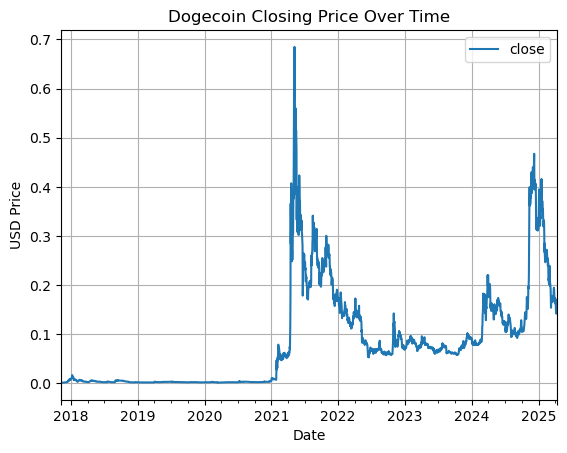

In [284]:

import matplotlib.pyplot as plt

ticker_symbol = f"{crypto_abb.upper()}-USD"

crypto_data = yf.Ticker(ticker_symbol).history(period="max")

crypto_data.index = pd.to_datetime(crypto_data.index)

for col in ["Dividends", "Stock Splits"]:
    if col in crypto_data.columns:
        del crypto_data[col]

crypto_data.columns = [c.lower() for c in crypto_data.columns]

crypto_data.plot.line(y="close", use_index=True, title=f"{crypto_name} Closing Price Over Time")
plt.ylabel("USD Price")
plt.xlabel("Date")
plt.grid(True)
plt.show()

In [286]:
crypto_data.index = crypto_data.index.tz_localize(None)
edits_df.index = edits_df.index.tz_localize(None)

merged_data = crypto_data.merge(edits_df, left_index=True, right_index=True)

In [288]:
merged_data["tomorrow"] = merged_data["close"].shift(-1)

In [290]:
merged_data["target"] = (merged_data["tomorrow"] > merged_data["close"]).astype(int)

In [292]:
merged_data["target"].value_counts()

target
0    1384
1    1330
Name: count, dtype: int64

In [294]:
merged_data

,open,high,low,close,volume,edit_count,sentiment,neg_sentiment,tomorrow,target
2017-11-09,0.001207,0.001415,0.001181,0.001415,6259550,0,0.000000,0.0,0.001163,0
2017-11-10,0.001421,0.001431,0.001125,0.001163,4246520,1,0.748121,0.0,0.001201,1
2017-11-11,0.001146,0.001257,0.001141,0.001201,2231080,0,0.000000,0.0,0.001038,0
2017-11-12,0.001189,0.001210,0.001002,0.001038,3288960,2,-0.715248,1.0,0.001211,1
2017-11-13,0.001046,0.001212,0.001019,0.001211,2481270,0,0.000000,0.0,0.001184,0
...,...,...,...,...,...,...,...,...,...,...
2025-04-10,0.160371,0.160377,0.149419,0.153666,1231567926,0,0.000000,0.0,0.160089,1
2025-04-11,0.153668,0.162140,0.153363,0.160089,864574135,0,0.000000,0.0,0.167611,1
2025-04-12,0.160089,0.169334,0.157877,0.167611,867802910,0,0.000000,0.0,0.162792,0
2025-04-13,0.167611,0.168489,0.161320,0.162792,874509965,0,0.000000,0.0,0.158571,0


In [296]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=50, random_state=1)

split_idx = int(len(merged_data) * 0.7)
train = merged_data.iloc[:split_idx]
test = merged_data.iloc[split_idx:]

predictors = ["close", "volume", "open", "high", "low", "edit_count", "sentiment", "neg_sentiment"]

model.fit(train[predictors], train["target"])

RandomForestClassifier(min_samples_split=50, random_state=1)

In [298]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["target"], preds)

0.5195530726256983

In [300]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="predictions")
    combined = pd.concat([test["target"], preds], axis=1)
    return combined

In [302]:
def backtest(data, model, predictors, start=1095, step=150):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [304]:
from xgboost import XGBClassifier

model = XGBClassifier(random_state=1, learning_rate=.1, n_estimators=200)
predictions = backtest(merged_data, model, predictors)

In [305]:
predictions["predictions"].value_counts()

predictions
0    949
1    670
Name: count, dtype: int64

In [308]:
precision_score(predictions["target"], predictions["predictions"])

0.5388059701492537

In [324]:
def compute_rolling(crypt):
    horizons = [2,7,60,365]
    new_predictors = ["close", "sentiment", "neg_sentiment"]

    for horizon in horizons:
        rolling_averages = crypt.rolling(horizon, min_periods=1).mean()

        ratio_column = f"close_ratio_{horizon}"
        merged_data[ratio_column] = crypt["close"] / rolling_averages["close"]
        
        edit_column = f"edit_{horizon}"
        merged_data[edit_column] = rolling_averages["edit_count"]

        rolling = merged_data.rolling(horizon, closed='left', min_periods=1).mean()
        trend_column = f"trend_{horizon}"
        merged_data[trend_column] = rolling["target"]

        new_predictors+= [ratio_column, trend_column, edit_column]
    return merged_data, new_predictors

In [326]:
merged_data, new_predictors = compute_rolling(merged_data.copy())

In [328]:
predictions = backtest(merged_data, model, new_predictors)

In [330]:
precision_score(predictions["target"], predictions["predictions"])

0.49040139616055844

In [332]:
predictions

,target,predictions
2021-11-08,0,0
2021-11-09,0,1
2021-11-10,1,1
2021-11-11,0,1
2021-11-12,1,1
...,...,...
2025-04-09,0,0
2025-04-10,1,1
2025-04-11,1,0
2025-04-12,0,1


In [334]:
for window in [2, 7, 60, 365]:
    merged_data[f"close_ratio_{window}"] = merged_data["close"] / merged_data["close"].shift(window)
    merged_data[f"trend_{window}"] = merged_data["close"].diff(window)
    merged_data[f"edit_{window}"] = merged_data["edit_count"].rolling(window).mean()

merged_data.dropna(inplace=True)

split_index = int(len(merged_data) * 0.7)
train = merged_data.iloc[:split_index]
test = merged_data.iloc[split_index:]

predictors = [
    "close", "sentiment", "neg_sentiment",
    "close_ratio_2", "trend_2", "edit_2",
    "close_ratio_7", "trend_7", "edit_7",
    "close_ratio_60", "trend_60", "edit_60",
    "close_ratio_365", "trend_365", "edit_365"
]

model.fit(train[predictors], train["target"])


preds = model.predict(test[predictors])
actual = test["target"].astype(int)

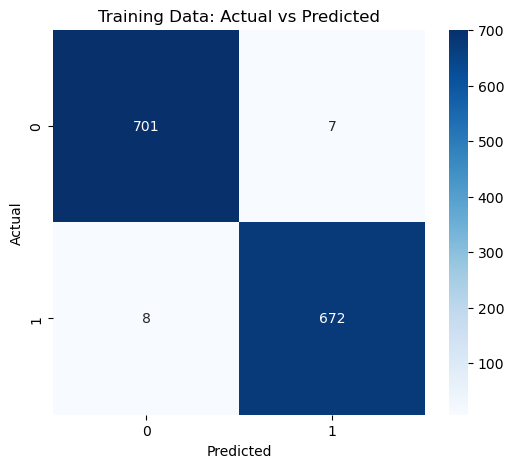

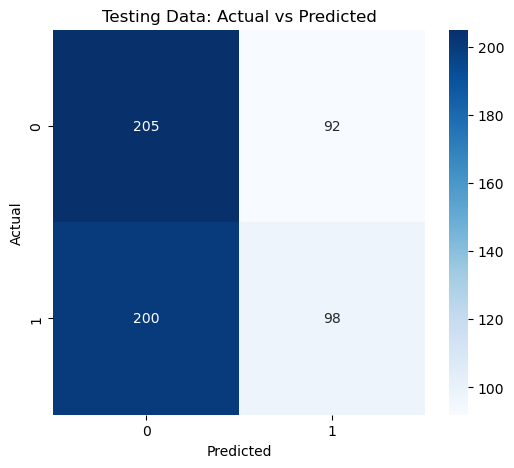

In [336]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

train_preds = model.predict(train[predictors])
plot_confusion_matrix(train["target"], train_preds, "Training Data: Actual vs Predicted")

test_preds = model.predict(test[predictors])
plot_confusion_matrix(test["target"], test_preds, "Testing Data: Actual vs Predicted")
